In [1]:
#%Matplotlib notebook
%matplotlib inline

#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
# Import SQLAlchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
# Find current working directory
import os
current_path = os.getcwd()
current_path

'/Users/Younes/Desktop/SurfUp'

In [4]:
#Set engine 
engine = create_engine("sqlite:///Hawaii.sqlite")

#Establish connection
conn = engine.connect()

In [5]:
#Reflect database
Base = automap_base()

#Reflect tables
Base.prepare(engine, reflect=True)

In [6]:
# Create  tables within the database
Base.metadata.create_all(conn)

In [7]:
# To push the objects made and query the server we use a Session object
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [8]:
#Show table names
Base.classes.keys()

#Save both table
Measurement = Base.classes.measurement
Station = Base.classes.station

#Create session 
session = Session(engine)

In [9]:
#query for dates and find latest
latestDate = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

#extract string from query object
latestDate = list(np.ravel(latestDate))[0]
#convert date string to datetime object
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')

#extract year, month, and day as integers
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

#calculate one year before latest date
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)

#query for dates and precipitation for the latest year
Rain_Data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

#convert query object to data frame and set index

Rain_Table = pd.DataFrame(Rain_Data)
Rain_Table.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


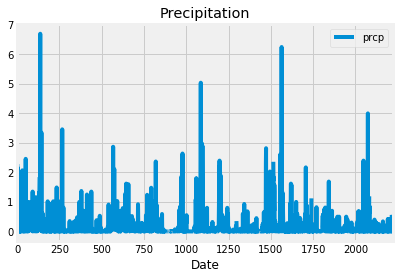

In [10]:
#sort by date
Sort_RainTable = Rain_Table.sort_index(ascending=True)

#Plot graph
Sort_RainTable.plot()
plt.title("Precipitation")
plt.xlabel("Date")

#Save png
plt.savefig('Precipitation.png')

In [11]:
# Count Stations:

StationCount = session.query(Station).count()
print("Station Count: ", StationCount)

Station Count:  9


In [24]:
# # Most active stations:

StationCount = (session.query(Measurement.station)
                       .group_by(Measurement.station)
                       .order_by(func.count(Measurement.station).desc())
                       .all())

StationCount = pd.DataFrame(StationCount)
StationCount

,station
0,USC00519281
1,USC00519397
2,USC00513117
3,USC00519523
4,USC00516128
5,USC00514830
6,USC00511918
7,USC00517948
8,USC00518838


In [27]:
#Last 12 months tobs

Temp_Data = (session.query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.date > yearBefore)
                    .filter(Measurement.station == stationID)
                    .order_by(Measurement.date)
                    .all())

Temp_Data = pd.DataFrame(Temp_Data)
Temp_Data.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


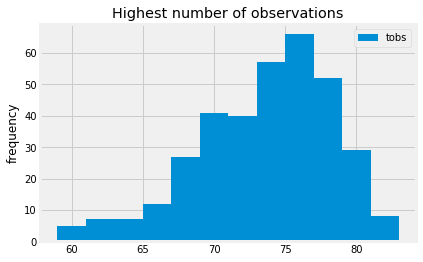

In [29]:
#Plot graph

Temp_Data.plot(kind='hist', bins=12)
plt.title("Highest number of observations")
plt.ylabel("frequency")

#Save png

plt.savefig('Temp_Data.png')

In [1]:
#Part 2: Flash

from flask import Flask, jsonify, render_template, abort

# initiating flask api

app = Flask(__name__)

@app.route('/')
def welcome():
    return jsonify({"Title": "Hawaii weather info",
        "description": "API for information about Hawaii stations, precipitation and temperature",
        "endpoints":["/api/v1.0/precipitation",
        "/api/v1.0/stations",
        "/api/v1.0/tobs",
        "/api/v1.0/<start>",
        "/api/v1.0/<start>/<end>"]})


@app.route("/api/v1.0/precipitation")

#Define precipiation 

def prcp():
    yearBefore = dt.date.today() - dt.timedelta(days=365)

    prcp_each_day = session.query(Measurement.date,func.sum(Measurement.prcp)).filter(Measurement.date >= prev_year).group_by(Measurement.date).order_by(Measurement.date).all()

    prcp_dict = dict(prcp_each_day)
    return jsonify(prcp_dict)

@app.route('/api/v1.0/stations')

#Define Stations
def stations():
    """return a json list of stations from the dataset."""

    stationquery = session.query(Station.station).all()

    stationlist = list(np.ravel(stationquery))
    
    return jsonify(stationlist)


@app.route('/api/v1.0/tobs')

#Definy tobs
def tobs():
    """Return a json list of Temperature Observations (tobs) for the previous year"""
    prev_year = dt.date.today() - dt.timedelta(days=365)

    tobsquery = session.query(Measurement.tobs).filter(Measurement.date >= prev_year).all()

    tobslist = list(np.ravel(tobsquery))

    return jsonify(tobslist)

#executing the error handler page using 404 abort
@app.errorhandler(404)
def page_not_found(e):
    
    return ("<h2> 404: Page Not Found </h2>"
            "Please enter a date in database range: <b>2010-01-01</b> to <b>2017-08-23</b>"),404



@app.route('/api/v1.0/<start>', methods=["GET"])

def tobsinfo_start(start):

    try:
        if start:
            
            sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

            calcs = session.query(*sel).filter(func.strftime('%Y-%m-%d',Measurement.date) >= start).one()


            return (
                    f"<h2> Temperature(F) informtion from {start} </h2>"
                    f"Minimum temp: {calcs[0]}<br>"
                    f"Average temp: {round(calcs[1],2)}<br>"
                    f"Maximum temp: {round(calcs[2],2)}<br>"
                    )
    except:
            abort(404)

@app.route('/api/v1.0/<start>/<end>')

def tobsinfo_start_end(start,end):
    try:
        if start and end: 
            
            sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

            calcs = session.query(*sel).filter(func.strftime('%Y-%m-%d',Measurement.date).between( start,end)).one()


            return (
                    f"<h2> Temperature informtion from {start} to {end}</h2>"
                    f"Minimum temperature: {calcs[0]}<br>"
                    f"Average temperature: {round(calcs[1],2)}<br>"
                    f"Maximum temperature: {round(calcs[2],2)}<br>"
                    )

    except:
            abort(404)


if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: 1

/Users/Younes/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
